In [82]:
import numpy as np
import pandas as pd
import random
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [83]:
inventory = {
    "Milk": 2.5,
    "Bread": 2.0,
    "Eggs": 3.0,
    "Juice": 4.0,
    "Butter": 3.5
}

items = list(inventory.keys())
prices = list(inventory.values())


In [84]:
def generate_purchase():
    quantities = np.random.randint(0, 4, size=len(items))

    if quantities.sum() == 0:
        quantities[random.randint(0, len(items)-1)] = 1

    total = sum(
        quantities[i] * prices[i]
        for i in range(len(items))
    )

    return quantities, round(total, 2)


data = []
for _ in range(5000):
    quantities, total = generate_purchase()
    row = {"total_amount": total}
    for i, item in enumerate(items):
        row[item] = quantities[i]
    data.append(row)

df = pd.DataFrame(data)


In [85]:
X = df[["total_amount"]]

# Binary item presence
y_items = (df[items] > 0).astype(int)

# Quantities
y_qty = df[items]


In [86]:
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X, y_items, test_size=0.2, random_state=42
)

item_model = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=300,
        random_state=42
    )
)

item_model.fit(X_train_i, y_train_i)


MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=300,
                                                       random_state=42))

In [87]:
X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(
    X, y_qty, test_size=0.2, random_state=42
)

qty_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=300,
        random_state=42
    )
)

qty_model.fit(X_train_q, y_train_q)


MultiOutputRegressor(estimator=RandomForestRegressor(n_estimators=300,
                                                     random_state=42))

In [88]:
MAX_QTY_PER_ITEM = 3
MAX_DISTINCT_ITEMS = 3
PRICE_TOLERANCE = 0.01


In [89]:
def predict_items_and_quantities(total_amount):
    # ---------- Stage 1: Item selection ----------
    probs = item_model.predict_proba(
        pd.DataFrame([[total_amount]], columns=["total_amount"])
    )

    item_scores = {
        items[i]: probs[i][0][1]
        for i in range(len(items))
    }

    selected_items = sorted(
        item_scores,
        key=item_scores.get,
        reverse=True
    )[:MAX_DISTINCT_ITEMS]

    # ---------- Stage 2: Quantity allocation ----------
    best_solution = None
    best_score = float("inf")

    ranges = [range(0, MAX_QTY_PER_ITEM + 1) for _ in selected_items]

    for quantities in product(*ranges):
        if sum(quantities) == 0:
            continue

        total = sum(
            quantities[i] * inventory[selected_items[i]]
            for i in range(len(selected_items))
        )

        if abs(total - total_amount) > PRICE_TOLERANCE:
            continue

        # Penalize large & complex baskets
        score = sum(q**2 for q in quantities)

        if score < best_score:
            best_score = score
            best_solution = quantities

    if best_solution is None:
        return {}

    return {
        selected_items[i]: best_solution[i]
        for i in range(len(selected_items))
        if best_solution[i] > 0
    }


In [90]:
for total in [7.5, 11.0, 15.0]:
    basket = predict_items_and_quantities(total)
    print(f"\nTotal Amount: {total}")
    print("Predicted Basket:", basket)



Total Amount: 7.5
Predicted Basket: {'Butter': 1, 'Juice': 1}

Total Amount: 11.0
Predicted Basket: {'Eggs': 1, 'Juice': 2}

Total Amount: 15.0
Predicted Basket: {'Bread': 1, 'Milk': 1, 'Butter': 3}


In [91]:
def calculate_total(basket):
    return sum(
        inventory[item] * qty
        for item, qty in basket.items()
    )

print("Reconstructed total:", calculate_total(basket))


Reconstructed total: 15.0


In [92]:
# =========================
# INFERENCE CELL
# =========================

def run_inference(total_amount, verbose=True):
    basket = predict_items_and_quantities(total_amount)

    reconstructed_total = sum(
        inventory[item] * qty
        for item, qty in basket.items()
    )

    if verbose:
        print("=" * 40)
        print(f"INFERENCE RESULT")
        print("=" * 40)
        print(f"Input Total Amount : {total_amount}")
        print("\nPredicted Basket:")
        if not basket:
            print("  No valid basket found")
        else:
            for item, qty in basket.items():
                price = inventory[item]
                print(f"  {item:8s} x {qty}  @ {price} = {qty * price}")

        print("-" * 40)
        print(f"Reconstructed Total: {reconstructed_total}")
        print("=" * 40)

    return basket


# 🔹 Example Inference Calls
run_inference(7.5)
run_inference(11.0)
run_inference(15.0)


INFERENCE RESULT
Input Total Amount : 7.5

Predicted Basket:
  Butter   x 1  @ 3.5 = 3.5
  Juice    x 1  @ 4.0 = 4.0
----------------------------------------
Reconstructed Total: 7.5
INFERENCE RESULT
Input Total Amount : 11.0

Predicted Basket:
  Eggs     x 1  @ 3.0 = 3.0
  Juice    x 2  @ 4.0 = 8.0
----------------------------------------
Reconstructed Total: 11.0
INFERENCE RESULT
Input Total Amount : 15.0

Predicted Basket:
  Bread    x 1  @ 2.0 = 2.0
  Milk     x 1  @ 2.5 = 2.5
  Butter   x 3  @ 3.5 = 10.5
----------------------------------------
Reconstructed Total: 15.0


{'Bread': 1, 'Milk': 1, 'Butter': 3}

In [93]:
import matplotlib.pyplot as plt

def plot_basket(basket, total_amount):
    if not basket:
        print("No items to plot.")
        return

    items_ = list(basket.keys())
    quantities = list(basket.values())
    prices_ = [inventory[item] for item in items_]
    costs = [quantities[i] * prices_[i] for i in range(len(items_))]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # -----------------------------
    # Plot 1: Quantities
    # -----------------------------
    axs[0].bar(items_, quantities, color="skyblue")
    axs[0].set_title("Predicted Item Quantities")
    axs[0].set_ylabel("Quantity")
    axs[0].set_xlabel("Item")

    # -----------------------------
    # Plot 2: Cost Contribution
    # -----------------------------
    axs[1].bar(items_, costs, color="lightgreen")
    axs[1].set_title("Cost Contribution per Item")
    axs[1].set_ylabel("Cost")
    axs[1].set_xlabel("Item")

    plt.suptitle(f"Predicted Basket for Total = {total_amount}", fontsize=14)
    plt.tight_layout()
    plt.show()


INFERENCE RESULT
Input Total Amount : 15.0

Predicted Basket:
  Bread    x 1  @ 2.0 = 2.0
  Milk     x 1  @ 2.5 = 2.5
  Butter   x 3  @ 3.5 = 10.5
----------------------------------------
Reconstructed Total: 15.0


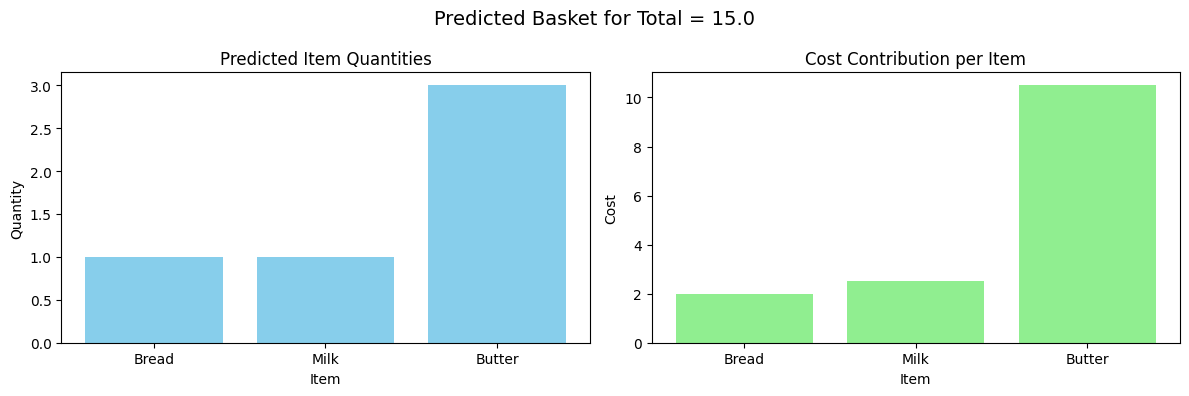

In [94]:
total = 15.0

basket = run_inference(total, verbose=True)
plot_basket(basket, total)
